# Polls

September 25

Copyright (c) 2014 Rafael Irizarry MIT License

In [4]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from pattern import web
import scipy.stats as stats
from scipy.stats import binom
from __future__ import division
import re

#nice defaults for matplotlib
from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

thep= 0.5534

In [2]:
###############
###############
###############
###############
###############
###############
###############
###############
###############
######## Polls
###############
###############
###############
###############
###############
###############
###############
###############
###############

In [5]:
# Import the html code for the table
URL = "http://www.pollster.com/08USPresGEMvO-2.html"
html = requests.get(URL).text
dom = web.Element(html)

# select out all rows of the table
rows = dom.by_tag('tr')

# add data from each row to a list
table = []
for row in rows:
    table_row = []
    data = row.by_tag('td')
    for value in data:
        table_row.append(web.plaintext(value.content))
    table.append(table_row)

In [6]:
# Gather data into a pandas dataframe
df = pd.DataFrame(table[1:], columns = table[0])
df.head()


,Pollster,Dates,N/Pop,McCain,Obama,Barr,Nader,Other,Undecided,Margin
0,Marist College,11/3/08,804 LV,43,52,-,-,3,2,+9D
1,GWU (Lake/Tarrance),11/2-3/08,400 LV,44,49,-,-,-,7,+5D
2,DailyKos.com (D)/Research 2000,11/1-3/08,1100 LV,46,51,1,1,0,1,+5D
3,IBD/TIPP,11/1-3/08,981 LV,44,52,-,-,4,-,+8D
4,Rasmussen,11/1-3/08,3000 LV,46,52,-,-,-,-,+6D


Let's assume we have a bag with with blue and red balls. The proportions are $p$ and $(1-p)$ respectively.  There are 131 million balls. How can we figure out $p$ ? 

Count them all? 

Take a sample of how many? 100?

Let's try it.

In [7]:
def pick(N, p):
    """
    Creates a list of N "R" and "B" binomially distributed with a probability p of getting "B"
    """
    result = [np.random.binomial(1, p) for i in xrange(N)]
    colors = ["R", "B"]
    return [colors[val] for val in result]

In [21]:
N = 100
p = thep
res = pick(N, p)
round(np.mean([x=='B' for x in res]), 2)

0.52

We got a number. Is that our guess?

Let's do it again.

In [22]:
res = pick(N, p)
round(np.mean([x=='B' for x in res]), 2)

0.59

In [23]:
B = 10000
avgs=[]
for i in xrange(B):
    res = pick(N, p)
    avgs.append(round(np.mean([x=='B' for x in res]), 2))

In [24]:
print avgs[1:25]

[0.57, 0.6, 0.5, 0.51, 0.58, 0.46, 0.57, 0.57, 0.59, 0.51, 0.47, 0.65, 0.53, 0.58, 0.52, 0.51, 0.6, 0.61, 0.59, 0.58, 0.46, 0.56, 0.59, 0.53]


This average is called a random variable. We only see it once, but it could have been many things. 

The distribution of many many outcomes is called the probability distribution function

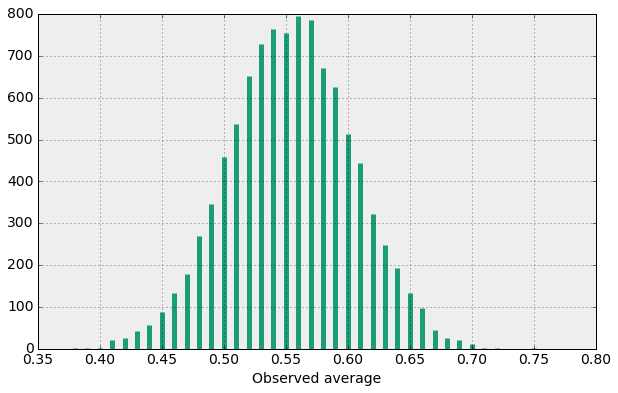

In [25]:
y, x = np.histogram(avgs, bins=np.arange(.35,.76,0.01))
plt.vlines(x[1:], 0, y, lw=5, colors=dark2_colors[0])
plt.xlabel("Observed average")
plt.ylabel("")
plt.show()


Want to guess $p$ now? 

So this histogram tells us the probabilty of any outcome. 

Now instead of saying what proportion, we say what is the chance, because the list of number is hypothetical. 

However, on a computer it is not hypothetical. We should create the list. This is called Monte Carlo simulation. But for this we need to know $p$ and in practice we don't know it, for example for polls.


So this distribution we can actually figure it out. It's called the binomial distribution:
$$\mathbb{P}(X=x)=\binom{N}{x}p^{x}(1-p)^{N-x}$$
This is the probability that exactly $x$ out of $N$ trials are positive, given that each trial has an independent probability $p$ of being positive.

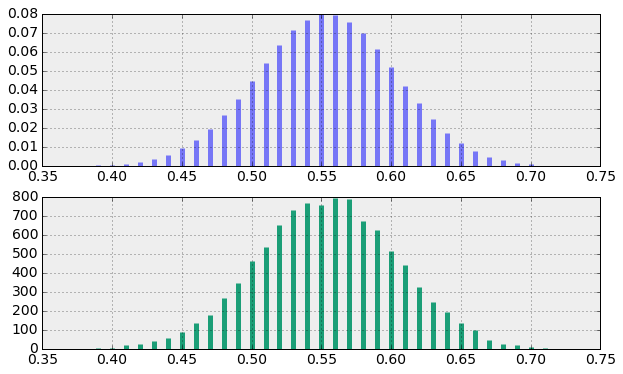

In [26]:
x2 = np.arange(35, 71, 1)
fig, ax = plt.subplots(2, 1)
ax[0].vlines(x2/100, 0, binom.pmf(x2, N, thep), colors='b', lw=5, alpha=0.5)
ax[1].vlines(x[1:], 0, y, lw=5, colors=dark2_colors[0])
ax[0].set_xlim(0.35, 0.75)
ax[1].set_xlim(0.35, 0.75)
plt.show()

This particular distribution is well approximated by the normal (bellcurve):
$$\phi(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$
We can use a statistical test on our empirical distribution to compare it to a theoretical normal distribution.

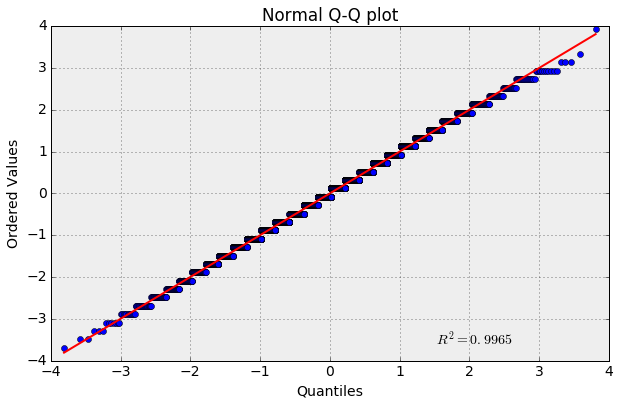

In [27]:
z = (avgs-np.mean(avgs))/np.std(avgs)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

We might use that later.

The standard deviation of this distribution, is referred to as a standard error. This distinction helps us communicate.

Ok so back to our problem. What is p? How close is our estimate to the actual proportion of balls?

Competition:
What is p? You can give a range. Smallest range wins but if outside eliminated.


Let's look at that distribution again

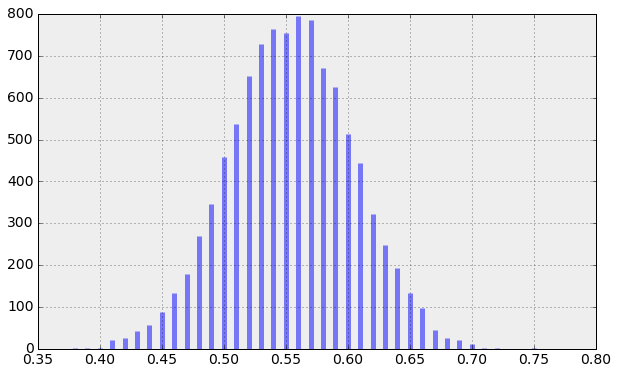

In [28]:
fig, ax = plt.subplots(1, 1)
ax.vlines(x[1:], 0, y, lw=5, colors='b', alpha=0.5)
plt.show()

In [30]:
print "This is the mean:", np.mean(avgs)
print "This is the SE:", np.std(avgs)

This is the mean: 0.553997
This is the SE: 0.0498651580866


Let's look at the probabilities:

In [33]:
mean = np.mean(avgs)
sd = np.std(avgs)
##students fill it in:
x = [[.40, .60], [.55, .56], [.551, .559], [.552, .555], [.5541, .5549]]

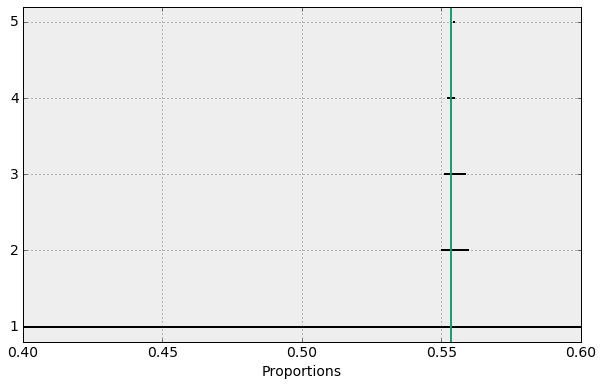

In [34]:
fig, ax = plt.subplots(1, 1)
for i in range(len(x)):
    ax.hlines(i+1, x[i][0], x[i][1])
    ax.vlines(p, 0.8, 5.2, alpha=0.8, colors=dark2_colors[0])
plt.ylim(0.8, 5.2)
plt.xlabel("Proportions")
plt.show()

95% (it can be any percent) Confidence intervals are random intervals that fall on the true $p$ 95% of the time.

In this example, I use the normal theory instead of the Monte Carlo approach.


In [40]:
def get_prange():
    """
    Returns array of N trials; each entry in the array is three elements list [i, a, b].
    i is either 1 or 0: 1 if a <= p <= b and 0 otherwise. a and b are calculated as mean
    plus/minus 2 standard deviations.
    """
    res = [np.random.binomial(1, p) for i in xrange(N)]
    avg = np.mean(res)
    res = avg + np.sqrt(avg*(1-avg)/N) * np.array([-2, 2])
    res = list(res)
    res = [(res[0]<=p and res[1]>=p)*1] + res
    return res

In [44]:
B = 50
N = 10000
cis = np.array([get_prange() for i in xrange(B)])
cis[:10]

array([[ 1.        ,  0.54656405,  0.56643595],
       [ 1.        ,  0.55177643,  0.57162357],
       [ 1.        ,  0.54476002,  0.56463998],
       [ 1.        ,  0.54335698,  0.56324302],
       [ 1.        ,  0.53794599,  0.55785401],
       [ 0.        ,  0.5328367 ,  0.5527633 ],
       [ 1.        ,  0.54606292,  0.56593708],
       [ 1.        ,  0.55187668,  0.57172332],
       [ 1.        ,  0.54686473,  0.56673527],
       [ 1.        ,  0.55127519,  0.57112481]])

In [45]:
colors = [dark2_colors[1], dark2_colors[0]]
cols = [colors[int(i)] for i in cis[:, 0]]
cis = cis[:, 1:3]

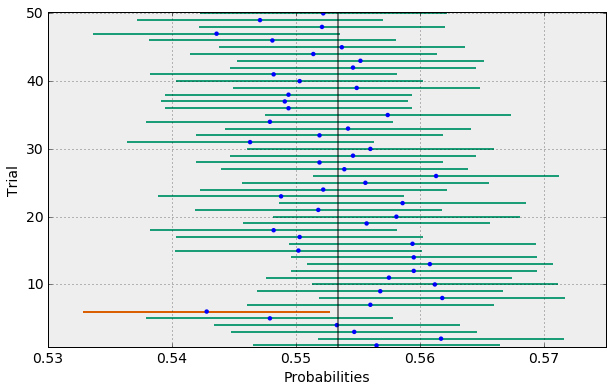

In [46]:
fig, ax = plt.subplots(1, 1)
for i in range(len(cis)):
    ax.hlines(i+1, cis[i][0], cis[i][1], color=cols[i])
    ax.scatter(np.mean(cis[i, :]), i+1, zorder = 2)
ax.vlines(p, 0.8, B+0.2, alpha=0.5)
plt.ylim(0.8, B+0.2)
plt.xlabel("Probabilities")
plt.ylabel("Trial")
plt.show()

## Back to the polls

There are undecided and third party candidates. But what do we care about?

In [48]:
#convert to number
Obama = np.array([float(a) for a in df["Obama"].values])
McCain = np.array([float(a) for a in df["McCain"].values])
df['diff'] = Obama - McCain

Let's extract day from the day it gives us:

In [49]:
#extract the year
year = [my_str.split("/")[-1] for my_str in df["Dates"].values]
year = [(a=='08')*1 for a in year]
full_year = ["2007", "2008"]
year = [full_year[i] for i in year]

In [51]:
#extract day
dates = df["Dates"].values
day = [my_str.split("-")[0] for my_str in dates]
day = [d[0]+"/"+d[1] for d in [a.split("/") for a in day]]
day = [day[i]+"/"+year[i] for i in xrange(len(day))]
day = [(pd.to_datetime(a) - pd.to_datetime("11/4/2008")).days for a in day]
df["day"] = day

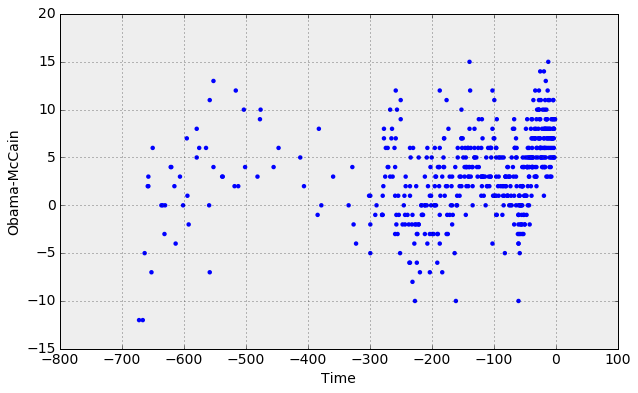

In [52]:
plt.scatter(df["day"], df["diff"])
plt.ylabel("Obama-McCain")
plt.xlabel("Time")
plt.show()

Lets get rid of everything more than 30 days left.

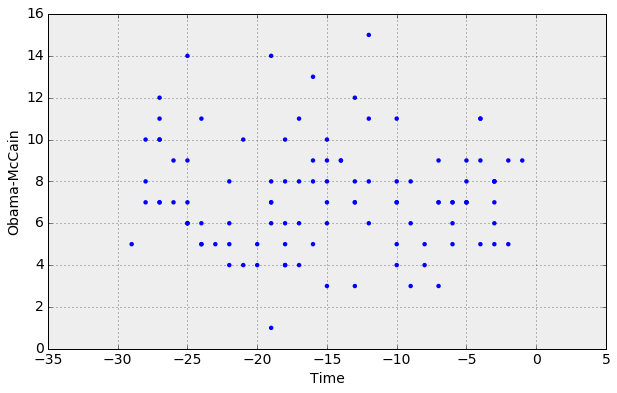

In [53]:
df=df[df["day"]>-30]
plt.scatter(df["day"], df["diff"])
plt.ylabel("Obama-McCain")
plt.xlabel("Time")
# plt.show()

Now let's do it by pollster

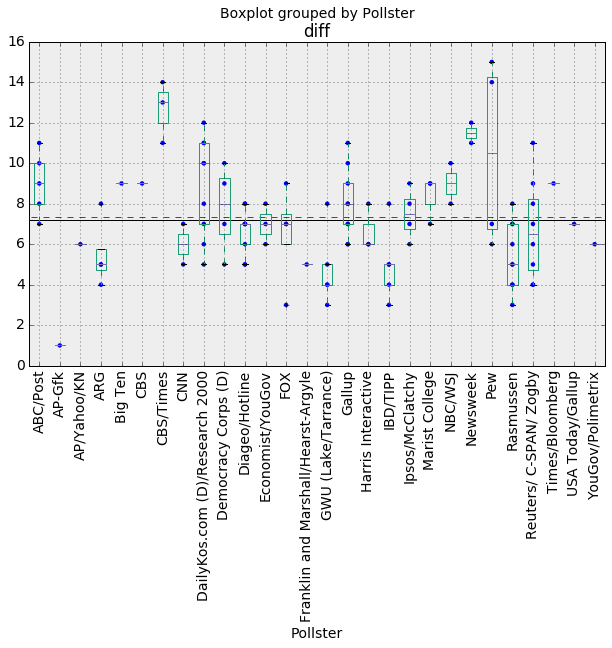

In [54]:
df.boxplot(column = "diff", by = "Pollster")

#get list of the alphabetic order of pollsters
x = list(set(df["Pollster"]))
x.sort()
x = [x.index(poll)+1 for poll in df["Pollster"]]

# plot all points
plt.scatter(y = df["diff"], x = x)

# plot solid line where the actual election result was (7.2) , red line at the average of all polls
plt.hlines(7.2, 0, len(set(df["Pollster"]))+1, lw=1)
plt.hlines(np.mean(df["diff"]), 0, len(set(df["Pollster"]))+1, lw=1, 
           linestyle='--', color='red')
plt.xticks(rotation=90)
plt.show()

The actual difference was 7.2